In [1]:
# !pip install torchvision
# !pip install torchinfo
# !pip install torchmetrics
# !pip install wandb -qU

We import the necessary packages

In [2]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import torchvision
from torch.utils.data import DataLoader, random_split
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as T
import torch
import torch.nn as nn
from torchvision.utils import make_grid
from torchvision.utils import save_image
from IPython.display import Image
import matplotlib.pyplot as plt
import numpy as np
import random
import torchmetrics
from torchinfo import summary
import torchvision.models as models
%matplotlib inline

We initialized GPU and login to W&B

In [3]:
enable_wandb =  True
use_gpu = True,
gpu_available = torch.cuda.is_available()

if enable_wandb:
  import wandb
  wandb.login()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: mwangcy0327 (bostonu-ba865). Use `wandb login --relogin` to force relogin


We sort the data into their respective folders

In [ ]:
# import os
# import shutil

# # Initialize an empty dictionary to store lists of image files for each grade
# list_of_image_files_dict = {}

# # Iterate over the range of grades (0 to 4 inclusive)
# for i in range(5): 
#     # Filter the DataFrame to select rows where the "Retinopathy grade" is equal to i
#     list_of_image_files_i = labels_training[labels_training["Retinopathy grade"] == i]["Image name"].tolist()
    
#     # Append ".jpg" to each filename and store it in the dictionary
#     list_of_image_files_dict[i] = [f"{filename}.jpg" for filename in list_of_image_files_i]

# # Define the path to the directory containing the image files
# source_path = "Disease Grading/1. Original Images/a. Training Set"

# # Define the unique classes
# unique_classes = ["Class0", "Class1", "Class2", "Class3", "Class4"]

# # Define the path to the testing set directory
# testing_set_dir = "Disease Grading/1. Original Images/a. Training Set"

# # Create class folders within the testing set directory
# for cls in unique_classes:
#     class_dir = os.path.join(testing_set_dir, cls)
#     os.makedirs(class_dir, exist_ok=True)

# # Move the image files to their respective class folders
# for i, cls in enumerate(unique_classes):
#     # Get the list of image files for the current class
#     list_of_image_files = list_of_image_files_dict[i]
    
#     # Create the class folder within the testing set directory
#     class_dir = os.path.join(testing_set_dir, cls)
#     os.makedirs(class_dir, exist_ok=True)
    
#     # Move the image files to the class folder
#     for image_file in list_of_image_files:
#         src_path = os.path.join(source_path, image_file)
#         dst_path = os.path.join(class_dir, image_file)
#         shutil.move(src_path, dst_path)

# # Initialize an empty dictionary to store lists of image files for each grade
# list_of_image_files_dict = {}

# # Iterate over the range of grades (0 to 4 inclusive)
# for i in range(5): 
#     # Filter the DataFrame to select rows where the "Retinopathy grade" is equal to i
#     list_of_image_files_i = labels_testing[labels_testing["Retinopathy grade"] == i]["Image name"].tolist()
    
#     # Append ".jpg" to each filename and store it in the dictionary
#     list_of_image_files_dict[i] = [f"{filename}.jpg" for filename in list_of_image_files_i]

# # Define the path to the directory containing the image files
# source_path = "Disease Grading/1. Original Images/b. Testing Set"

# # Define the unique classes
# unique_classes = ["Class0", "Class1", "Class2", "Class3", "Class4"]

# # Define the path to the testing set directory
# testing_set_dir = "Disease Grading/1. Original Images/b. Testing Set"

# # Create class folders within the testing set directory
# for cls in unique_classes:
#     class_dir = os.path.join(testing_set_dir, cls)
#     os.makedirs(class_dir, exist_ok=True)

# # Move the image files to their respective class folders
# for i, cls in enumerate(unique_classes):
#     # Get the list of image files for the current class
#     list_of_image_files = list_of_image_files_dict[i]
    
#     # Create the class folder within the testing set directory
#     class_dir = os.path.join(testing_set_dir, cls)
#     os.makedirs(class_dir, exist_ok=True)
    
#     # Move the image files to the class folder
#     for image_file in list_of_image_files:
#         src_path = os.path.join(source_path, image_file)
#         dst_path = os.path.join(class_dir, image_file)
#         shutil.move(src_path, dst_path)

We initialize the configs

In [4]:
configs = {
    "experiment_name": "Baseline",
    "freeze_feature_extraction_layers": False,
    "pretrained": False,
    "efficientnet": False, 
    "data_augmentation": True,
    "transferlearning": True,

    # Data
    "img_dimensions" : (3, 498, 600),
    "batch_size" : 64,
    "num_classes" : 5,

    # CNN
    "filter_sizes" : [4,8,16],
    "kernel_size" : 5,
    "stride": 1,
    "padding":0,

    #Optimzation
    "learning_rate" : 0.0001,
    "epochs" : 100,
    "weight_decay" : 0.00001,
    "patience" : 5
}

We load the data

In [5]:
training_path = "Disease Grading/1. Original Images/a. Training Set"
testing_path = "Disease Grading/1. Original Images/b. Testing Set"

if configs["data_augmentation"]:
    transform = transforms.Compose([
        transforms.RandomHorizontalFlip(0.5),
        transforms.Resize([448, 500]),
        transforms.Pad((0, 10, 0, 10)),
        transforms.RandomRotation(45),
        transforms.ToTensor(),
        #transforms.Normalize(mean=[0.5944, 0.2908, 0.0962], std=[0.2047, 0.1284, 0.0866])
    ])
else:
    transform = transforms.Compose([
        transforms.Resize([448, 500]),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5944, 0.2908, 0.0962], std=[0.2047, 0.1284, 0.0866])
    ])

test_transform = transforms.Compose([
    transforms.Resize(([448, 600])),
    transforms.Pad((0, 10, 0, 10)),
    transforms.ToTensor()
    ])

train_dataset = torchvision.datasets.ImageFolder(training_path, transform = transform)
train_dataset, val_dataset = random_split(train_dataset, [0.8, 0.2])
test_dataset = torchvision.datasets.ImageFolder(testing_path, transform = test_transform)

# Data loaders
train_loader = DataLoader(dataset=train_dataset, batch_size = configs["batch_size"], shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size = configs["batch_size"], shuffle=False)
test_loader = DataLoader(dataset=test_dataset, batch_size = configs["batch_size"], shuffle=False)

We calculate the mean and std for the testing data

In [6]:
total_sum = 0
total_sum_squared = 0
total_count = 0

for images, _ in test_loader:
    total_sum += torch.sum(images, dim=(0, 2, 3))
    total_sum_squared += torch.sum(images ** 2, dim=(0, 2, 3))
    total_count += images.size(0) * images.size(2) * images.size(3)

mean = total_sum / total_count
mean_squared = total_sum_squared / total_count

std = torch.sqrt(mean_squared - mean ** 2)

print("Mean pixel values:", mean)
print("Standard deviation of pixel values:", std)

Mean pixel values: tensor([0.4204, 0.1993, 0.0562])
Standard deviation of pixel values: tensor([0.3101, 0.1589, 0.0672])


In [7]:
for images, _ in train_loader:
    print(images.shape)
    break

torch.Size([64, 3, 468, 500])


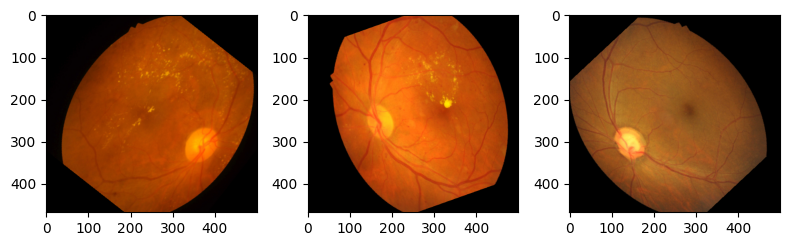

In [8]:
plt.figure(figsize=(8, 8))

iterator = iter(train_loader)
for i in range(3):

    plt.subplot(1, 3, i+1)
    image, _ = next(iterator)
    image_show = image[i].permute(1,2,0)
    plt.imshow(image_show)

plt.tight_layout()
plt.show()

In [9]:
train_dataset[0][0].shape

torch.Size([3, 468, 500])

We loaded the model and moved it to the GPU if available

In [10]:
import torchvision.models as models

model = torch.hub.load("pytorch/vision", "efficientnet_b2", weights="EfficientNet_B2_Weights.DEFAULT")

if gpu_available and use_gpu:
  model = model.cuda()

Using cache found in /usr4/ba820/mwangcy/.cache/torch/hub/pytorch_vision_main


In [11]:
print(model)

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

We changed the last layer and froze all layers if freeze_feature_extraction_layers is set to true

In [12]:
model.classifier = torch.nn.Sequential(torch.nn.Dropout(p=0.3, inplace=True), torch.nn.Linear(1408, 100), torch.nn.ReLU(), torch.nn.Linear(100, configs["num_classes"]))

if configs["freeze_feature_extraction_layers"] == True:
    for param in model.parameters():
        param.requires_grad = False
    for param in model.classifier.parameters():
        param.requires_grad = True

summary(model)

Layer (type:depth-idx)                                  Param #
EfficientNet                                            --
├─Sequential: 1-1                                       --
│    └─Conv2dNormActivation: 2-1                        --
│    │    └─Conv2d: 3-1                                 864
│    │    └─BatchNorm2d: 3-2                            64
│    │    └─SiLU: 3-3                                   --
│    └─Sequential: 2-2                                  --
│    │    └─MBConv: 3-4                                 1,448
│    │    └─MBConv: 3-5                                 612
│    └─Sequential: 2-3                                  --
│    │    └─MBConv: 3-6                                 6,004
│    │    └─MBConv: 3-7                                 10,710
│    │    └─MBConv: 3-8                                 10,710
│    └─Sequential: 2-4                                  --
│    │    └─MBConv: 3-9                                 16,518
│    │    └─MBConv: 3-10       

We load the weights from the best previous run

In [13]:
model.load_state_dict(torch.load('best_model_weights.pth'))

<All keys matched successfully>

In [14]:
def get_accuracy(dataloader, model):
  device = 'cuda' if torch.cuda.is_available() else 'cpu'
  acc = torchmetrics.Accuracy(task = "multiclass", num_classes = configs["num_classes"]).to(device)

  with torch.no_grad():
      for images, labels in dataloader:
          if gpu_available and use_gpu:
            images = images.cuda()
            labels = labels.cuda()

          outputs = model(images) # get predictions

          # Update accuracy for this batch
          acc.update(outputs, labels)


      # Compute the accuracy
      acc = acc.compute()

      return acc

def get_loss(loader):
  with torch.no_grad(): # Anything under torch.no_grad will be calculated with no gradients. Can only be used for testing, not training!

    loss = 0
    for i, (images, labels) in enumerate(loader): # The batches.
          # step1: Move data to cuda. Make sure the model is on cuda too!
          if gpu_available and use_gpu:
            images = images.cuda()
            labels = labels.cuda()

          # step2: Forward pass
          outputs = model(images)

          # step 3: calculate the loss.
          loss = loss + criterion(outputs, labels)
    return loss/ len(loader)

class EarlyStopper:
    def __init__(self, patience=1):
        self.patience = patience
        self.counter = 0
        self.min_validation_loss = float('inf')

    def early_stop(self, validation_loss):
        # If the new loss is lower than the old loss, reset the counter!
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
            # Keep track of the best model by saving it on the hard drive.
            torch.save(model.state_dict(), "./best_model.pt")
        # otherwise, increment the counter.
        elif validation_loss > self.min_validation_loss:
            self.counter += 1
            # If there has been too many epochs with the loss being high, terminate.
            if self.counter >= self.patience:
                return True
        return False

In [15]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=configs["learning_rate"], weight_decay=configs["weight_decay"])

In [16]:
if enable_wandb:
  wandb.init(
    project= "BA865 Project Neural Networks Report",
    name=configs["experiment_name"],
    config=configs)

if gpu_available and use_gpu:
  model = model.cuda()

In [17]:
early_stopper = EarlyStopper(patience = configs["patience"])
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.3, patience=3)

lowest_val_loss = float('inf')
best_model_weights = None

# Training loop
for epoch in range(configs["epochs"]): # The epochs.
    for i, (images, labels) in enumerate(train_loader): # The batches.
        # step 1: Zero out the gradients.
        optimizer.zero_grad()

        # step 1.1 move data to cuda. Make sure the model is on cuda too!
        if gpu_available and use_gpu:
          images = images.cuda()
          labels = labels.cuda()

        # step2: Forward pass
        outputs = model(images)

        # step 3: calculate the loss.
        loss = criterion(outputs, labels)

        # step 4: Backward pass
        loss.backward()
        optimizer.step()

        # Print the loss
        if i %2 == 0:
          print("Epoch", epoch+ 1, " batch", i+1, ". Training Loss: ", loss.item())
          if enable_wandb:
            wandb.log({"loss": loss})

    # Compute total train accuracy
    train_acc = get_accuracy(train_loader, model)
    test_acc = get_accuracy(val_loader, model)

    validation_loss = get_loss(val_loader)
    wandb.log({"val_loss": validation_loss})

    print(f'Epoch [{epoch + 1}/{configs["epochs"]}], LR: {optimizer.param_groups[0]["lr"]}, Validation Loss: {validation_loss.item():.4f}, Train Accuracy: {train_acc.item():.4f}, Validation Accuracy: {test_acc.item():.4f}')
    if enable_wandb:
      wandb.log({"epoch": epoch + 1, "LR": {optimizer.param_groups[0]['lr']}, "train_accuracy": train_acc.item(), "val_accuracy": test_acc.item()})
    
      predictions = []
    
      with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs.cuda()) 
            _, predicted = torch.max(outputs, 1)
            predictions.extend(predicted.tolist())  # Append predictions to the list
    
      wandb.log({"conf_mat": wandb.plot.confusion_matrix(probs=None, 
                                                    y_true=test_loader.dataset.targets, 
                                                    preds=predictions, 
                                                    class_names=test_loader.dataset.classes)})

    scheduler.step(validation_loss)
    
    if validation_loss < lowest_val_loss:
        print("New lowest validation loss found. Saving model...")
        lowest_val_loss = validation_loss
        best_model_weights = model.state_dict()

    # Save the best model weights
    torch.save(best_model_weights, 'best_model_weights_no_norm.pth')

    if early_stopper.early_stop(validation_loss):
        print("Validation loss hasn't dropped. Early stopping!")
        break

Epoch 1  batch 1 . Training Loss:  0.46007218956947327
Epoch 1  batch 3 . Training Loss:  0.38681846857070923
Epoch 1  batch 5 . Training Loss:  0.21580088138580322
Epoch [1/100], LR: 0.0001, Validation Loss: 0.6119, Train Accuracy: 0.9003, Validation Accuracy: 0.8049
New lowest validation loss found. Saving model...
Epoch 2  batch 1 . Training Loss:  0.2101583480834961
Epoch 2  batch 3 . Training Loss:  0.4877110719680786
Epoch 2  batch 5 . Training Loss:  0.37189942598342896
Epoch [2/100], LR: 0.0001, Validation Loss: 0.5836, Train Accuracy: 0.9094, Validation Accuracy: 0.7561
New lowest validation loss found. Saving model...
Epoch 3  batch 1 . Training Loss:  0.27416539192199707
Epoch 3  batch 3 . Training Loss:  0.2211020141839981
Epoch 3  batch 5 . Training Loss:  0.20781195163726807
Epoch [3/100], LR: 0.0001, Validation Loss: 0.5210, Train Accuracy: 0.9124, Validation Accuracy: 0.7927
New lowest validation loss found. Saving model...
Epoch 4  batch 1 . Training Loss:  0.232658267

In [18]:
if enable_wandb:
  wandb.finish()

epoch,▁▂▃▄▅▅▆▇█
loss,▇▆▃▃█▆▄▃▃▃▃▅▄▂▅▃▂▂▅▃▁▃▃▃▂▃▁
train_accuracy,▁▂▃█▆███▅
val_accuracy,▇▄▆█▅▁▇██
val_loss,▄▃▁▁▁█▃▃▂
epoch,9
loss,0.11043
train_accuracy,0.92749
val_accuracy,0.81707
val_loss,0.54354


We calculate the accuracy of the model on the testing data

In [19]:
test_accuracy = get_accuracy(test_loader, model)
print(f'Test Accuracy: {test_accuracy.item():.4f}')

Test Accuracy: 0.3981
